# Active Search

在 **Active Search** 策略中，模型不依赖预先提供的训练数据，而是从测试数据中直接进行优化。具体而言，模型会在测试时针对每个单独的输入问题执行多轮优化，旨在通过主动搜索生成最优解。该过程可以被视为一种无监督的在线优化，目标是针对每个具体问题找到最优解。

每次测试时，模型会随机采样不同的解，并在每轮采样后根据反馈信息更新自身的参数。这一迭代过程继续进行，直至找到最优解或达到预设的采样次数。

In [1]:
# 导入库
import os
import math
import argparse
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 定义TSPDataset类
class TSPDataset(Dataset):
    def __init__(self, num_nodes, num_samples, random_seed=42):
        super().__init__()
        
        self.num_nodes = num_nodes
        self.num_samples = num_samples
        self.sample = torch.rand(self.num_nodes, 2) 

        self.permutations = []
        for idx in range(num_samples):
            seed = random_seed + idx
            torch.manual_seed(seed)
            perm = torch.randperm(num_nodes)
            self.permutations.append(perm)

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.sample[self.permutations[idx]]  

In [3]:
# 定义reward函数
def reward(sols):
    # sols: (batch_size, seq_len, input_size)
    # lengths: (batch_size,)
    lengths = torch.norm(sols[:, 1:, :] - sols[:, :-1, :], dim=2).sum(dim=1)
    lengths += torch.norm(sols[:, -1, :] - sols[:, 0, :], dim=1)
    return lengths

In [4]:
# 定义ResidualConnection类
class ResidualConnection(nn.Module):
    def __init__(self, module):
        super().__init__()
        
        self.module = module
    
    def forward(self, x):
        return x + self.module(x)

In [5]:
# 定义Normalization类
class Normalization(nn.Module):
    def __init__(self, embedding_size, normalization='batch'):
        super().__init__()
        
        normalizer = {
            'batch': nn.BatchNorm1d,
            'instance': nn.InstanceNorm1d,
        }.get(normalization, None)
        assert normalizer is not None, f'Unsupported normalization type: {normalization}'
        
        self.normalizer = normalizer(embedding_size, affine=True)
        
        self._init_parameters()
        
    def _init_parameters(self):
        if hasattr(self.normalizer, 'weight') and self.normalizer.weight is not None:
            nn.init.uniform_(self.normalizer.weight, 0., 1.)
        if hasattr(self.normalizer, 'bias') and self.normalizer.bias is not None:
            nn.init.zeros_(self.normalizer.bias)
            
    def forward(self, x):
        if isinstance(self.normalizer, nn.BatchNorm1d):
            return self.normalizer(x.view(-1, x.size(-1))).view(*x.size())
        else:
            return self.normalizer(x.permute(0, 2, 1)).permute(0, 2, 1)

In [6]:
# 定义MultiHeadAttention类
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, query_size, key_size, value_size, embedding_size, dropout=0.1):
        super().__init__()
        assert embedding_size % num_heads == 0
        
        self.num_heads = num_heads
        self.embedding_size = embedding_size
        self.head_size = embedding_size // num_heads
        
        self.W_q = nn.Linear(query_size, embedding_size)
        self.W_k = nn.Linear(key_size, embedding_size)
        self.W_v = nn.Linear(value_size, embedding_size)
        self.W_o = nn.Linear(embedding_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        
        self.scale_factor = math.sqrt(self.head_size)
        
        self._init_parameters()
        
    def _init_parameters(self):
        for param in self.parameters():
            std = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-std, std)
        
    def forward(self, q, k=None, v=None, mask=None):
        # q: (batch_size, q_len, query_size)
        # k: (batch_size, seq_len, key_size)
        # v: (batch_size, seq_len, value_size)
        # mask: (batch_size, seq_len)
        if k is None:
            k = q
            v = q
        q_len = q.size(1)
        batch_size, seq_len, _ = k.size()
        
        # Q: (batch_size, q_len, embedding_size)
        Q = self.W_q(q)
        # K, V: (batch_size, seq_len, embedding_size)
        K = self.W_k(k)
        V = self.W_v(v)
        
        # Q: (batch_size, num_heads, q_len, head_size)
        Q = Q.view(batch_size, q_len, self.num_heads, self.head_size).transpose(1, 2)
        # K, V: (batch_size, num_heads, seq_len, head_size)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        
        # attn_scores: (batch_size, num_heads, q_len, seq_len)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale_factor
        if mask is not None:
            # mask: (batch_size, num_heads, q_len, seq_len)
            mask = mask.unsqueeze(1).unsqueeze(1).expand(-1, self.num_heads, q_len, -1)
            mask_clone = mask.clone().bool()
            attn_scores = attn_scores.masked_fill(mask_clone, float('-inf'))
            
        # attn_weights: (batch_size, num_heads, q_len, seq_len)
        attn_weights = F.softmax(attn_scores, -1)
        attn_weights = self.dropout(attn_weights)
        
        # attn_output: (batch_size, num_heads, q_len, head_size)
        attn_output = torch.matmul(attn_weights, V)
        # attn_output: (batch_size, q_len, embedding_size)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, q_len, self.embedding_size)
        
        # output: (batch_size, q_len, embedding_size)
        output = self.W_o(attn_output)
        
        return output

In [7]:
# 定义MultiHeadAttentionLayer类
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, num_heads, embedding_size, FF_hidden_size=512, normalization='batch', dropout=0.1):
        super().__init__()
        
        self.attention = ResidualConnection(
            MultiHeadAttention(num_heads, embedding_size, embedding_size, embedding_size, embedding_size, dropout)
        )
        self.norm1 = Normalization(embedding_size, normalization)
        
        self.feed_forward = ResidualConnection(
            nn.Sequential(
                nn.Linear(embedding_size, FF_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(FF_hidden_size, embedding_size),
            ) if FF_hidden_size > 0 else nn.Linear(embedding_size, embedding_size)
        )
        self.norm2 = Normalization(embedding_size, normalization)
        
    def forward(self, x):
        x = self.norm1(self.attention(x))
        x = self.norm2(self.feed_forward(x))
        return x

In [8]:
# 定义Encoder类
class Encoder(nn.Module):
    def __init__(self, num_heads, embedding_size, num_layers, input_size=None, FF_hidden_size=512, normalization='batch', dropout=0.1):
        super().__init__()
        
        self.embedding = nn.Linear(input_size, embedding_size) if input_size is not None else None
        self.layers = nn.Sequential(*(
            MultiHeadAttentionLayer(num_heads, embedding_size, FF_hidden_size, normalization, dropout)
            for _ in range(num_layers)
        ))
        
    def forward(self, inputs):
        # inputs: (batch_size, seq_len, input_size)
        if self.embedding is not None:
            # embedded: (batch_size, seq_len, embedding_size)
            embedded = self.embedding(inputs)
        else:
            embedded = inputs
        # node_embedding: (batch_size, seq_len, embedding_size)
        node_embedding = self.layers(embedded)
        return node_embedding

In [9]:
# 定义Decoder类
class Decoder(nn.Module):
    def __init__(self, num_heads, embedding_size, C=10, dropout=0.1, temperature=None, argmax=False):
        super().__init__()
        assert embedding_size % num_heads == 0
        
        self.num_heads = num_heads
        self.embedding_size = embedding_size
        self.C = C
        self.temperature = temperature
        self.argmax = argmax
        
        self.input_placeholder = nn.Parameter(torch.zeros(2 * embedding_size))
        
        self.multihead_attention = MultiHeadAttention(num_heads, 3 * embedding_size, embedding_size, embedding_size, embedding_size, dropout)
        
        self.W_q = nn.Linear(embedding_size, embedding_size)
        self.W_k = nn.Linear(embedding_size, embedding_size)
        self.scale_factor = math.sqrt(embedding_size)
        
        self._init_parameters()
        
    def _init_parameters(self):
        for param in self.parameters():
            std = 1. / math.sqrt(param.size(-1))
            param.data.uniform_(-std, std)
    
    def forward(self, node_embedding):
        # node_embedding: (batch_size, seq_len, embedding_size)
        batch_size, seq_len, embedding_size = node_embedding.size()
        assert self.embedding_size == embedding_size
        
        # graph_embedding: (batch_size, embedding_size)
        graph_embedding = node_embedding.mean(dim=1)
        
        # mask: (batch_size, seq_len)
        mask = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=node_embedding.device)
        
        idxs = None
        first_node_context, current_node_context = None, None
        prev_probs, prev_idxs = [], []
        
        for _ in range(seq_len):
            if first_node_context is None:
                # context_embedding: (batch_size, 3 * embedding_size)
                context_embedding = torch.cat((graph_embedding, self.input_placeholder.unsqueeze(0).expand(batch_size, -1)), dim=1)
            else:
                # context_embedding: (batch_size, 3 * embedding_size)
                context_embedding = torch.cat((graph_embedding, current_node_context, first_node_context), dim=1)
                
            # attn_output: (batch_size, embedding_size)
            attn_output = self.multihead_attention(context_embedding.unsqueeze(1), node_embedding, node_embedding, mask).squeeze(1)
            
            # query: (batch_size, embedding_size)
            query = self.W_q(attn_output)
            # key: (batch_size, seq_len, embedding_size)
            key = self.W_k(node_embedding)
            
            # logits: (batch_size, seq_len)
            logits = torch.matmul(query.unsqueeze(1), key.transpose(-2, -1)).squeeze(1) / self.scale_factor
            logits = self.C * torch.tanh(logits)
            mask_clone = mask.clone().bool()
            logits = logits.masked_fill(mask_clone, float('-inf'))
            
            # probs: (batch_size, seq_len)
            probs = F.softmax(logits, dim=-1) if self.temperature is None else F.softmax(logits / self.temperature, dim=-1)
            # idxs: (batch_size,)
            if self.argmax:
                idxs = torch.argmax(probs, 1)
            else:
                idxs = torch.multinomial(probs, 1).squeeze(1)
            mask[torch.arange(batch_size), idxs] = True
            
            
            prev_probs.append(probs[torch.arange(batch_size), idxs])
            prev_idxs.append(idxs)
            
            # current_node_context: (batch_size, embedding_size)
            current_node_context = node_embedding[torch.arange(batch_size), idxs, :]
            if first_node_context is None:
                first_node_context = current_node_context
                
        # prev_probs, prev_idxs: (batch_size, seq_len)
        prev_probs = torch.stack(prev_probs, dim=1)
        prev_idxs = torch.stack(prev_idxs, dim=1)
        return prev_probs, prev_idxs

In [10]:
# 定义Actor类
class Actor(nn.Module):
    def __init__(self, num_heads, embedding_size, num_layers, input_size, FF_hidden_size, normalization, dropout, C, temperature, argmax, reward):
        super().__init__()
        
        self.reward = reward
        
        self.encoder = Encoder(num_heads, embedding_size, num_layers, input_size, FF_hidden_size, normalization, dropout)
        self.decoder = Decoder(num_heads, embedding_size, C, dropout, temperature, argmax)
        
    def forward(self, inputs):
        # inputs: (batch_size, seq_len, input_size)
        # node_embedding: (batch_size, seq_len, input_size)
        node_embedding = self.encoder(inputs)
        # probs, idxs: (batch_size, seq_len)
        probs, idxs = self.decoder(node_embedding)
        # actions: (batch_size, seq_len, input_size)
        actions = inputs[torch.arange(inputs.size(0)).unsqueeze(1), idxs]
        # rewards: (batch_size,)
        rewards = self.reward(actions)
        return rewards, idxs, probs

In [11]:
# 训练
def train(args, train_dataset):
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    
    actor = Actor(args.num_heads, args.embedding_size, args.num_layers, args.input_size, args.FF_hidden_size, args.normalization, args.dropout, args.C, args.temperature, False, reward).to(args.device)
    optimizer = optim.Adam(actor.parameters(), lr=args.lr)
    
    step = 0
    baseline = 0
    best_length = float('inf')
    best_tour, best_input = None, None
    writer = SummaryWriter()
    model_path = os.path.join(args.output_dir, args.name)
    
    for epoch in range(args.n_epochs):
        for batch_id, train_batch in enumerate(train_loader):
            actor.train()
            
            # inputs: (batch_size, seq_len, input_size)
            inputs = train_batch.to(args.device)
            # rewards: (batch_size,)
            # idxs, probs: (batch_size, seq_len)
            rewards, idxs, probs = actor(inputs)
            # log_probs: (batch_size)
            log_probs = torch.log(probs.clamp(min=1e-10)).sum(dim=1)
            baseline = baseline * args.beta + rewards.mean().item() * (1 - args.beta)
            # advantage: (batch_size,)
            advantage = rewards - baseline
            # reinforce: (batch_size,)
            reinforce = advantage.detach() * log_probs
            actor_loss = reinforce.mean()
            
            optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(actor.parameters(), args.max_grad_norm)
            optimizer.step()
            
            writer.add_scalar('Actor_Loss/train', actor_loss.item(), step)
            writer.add_scalar('Length/train', rewards.mean().item(), step)       
            best_reward, best_idx = rewards.min(0)
            if best_reward < best_length:
                best_length = best_reward
                best_tour = idxs[best_idx].clone()
                best_input = inputs[best_idx].clone()
            step += 1
            
            if batch_id % 100 == 0:
                print(f"Epoch [{epoch + 1}/{args.n_epochs}], Batch [{batch_id + 1}/{len(train_loader)}], "
                      f"Actor Loss: {actor_loss.item():.4f}, Reward: {rewards.mean().item():.4f}, "
                      f"Best Length: {best_length:.4f}")
        
    plot_tsp_path(args, best_input, best_tour, best_length)
    
    writer.close()

In [12]:
def plot_tsp_path(args, inputs, idxs, rewards):
    # inputs: (seq_len, 2)
    # idxs: (seq_len)
    # rewards: (1,)
    inputs = inputs.cpu().numpy()
    idxs = idxs.cpu().numpy()
    rewards = rewards.cpu().numpy()

    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(f'{args.name} - Length: {rewards:.3f}')
    
    for j in range(len(idxs)):
        x1, y1 = inputs[idxs[j - 1]]
        x2, y2 = inputs[idxs[j]]
        plt.plot([x1, x2], [y1, y2], 'bo-') 

    plt.scatter(inputs[:, 0], inputs[:, 1], c='red')  
    plt.scatter(inputs[0, 0], inputs[0, 1], c='yellow')  
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [13]:
# 参数
args = argparse.Namespace()
args.seq_len = 50
args.n_epochs = 30
args.batch_size = 512
args.lr = 1e-4
args.num_heads = 8
args.embedding_size = 128
args.num_layers = 3
args.input_size = 2
args.FF_hidden_size = 512
args.normalization = 'batch'
args.dropout = 0.1
args.C = 10 
args.temperature = None
args.max_grad_norm = 1.
args.alpha = 0.05
args.beta = 0.99
args.output_dir = 'output'
args.name = 'DRL4TSP_Attention_ActiveSearch_TSP' + str(args.seq_len)
args.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.makedirs(args.output_dir, exist_ok=True)

train_dataset = TSPDataset(args.seq_len, 51200)

Training started...
Epoch [1/30], Batch [1/100], Actor Loss: -3643.9551, Reward: 25.0186, Best Length: 20.4292
Epoch [2/30], Batch [1/100], Actor Loss: -158.8533, Reward: 13.0274, Best Length: 9.9110
Epoch [3/30], Batch [1/100], Actor Loss: 64.8725, Reward: 9.1581, Best Length: 6.9265
Epoch [4/30], Batch [1/100], Actor Loss: 41.8810, Reward: 7.9609, Best Length: 6.3865
Epoch [5/30], Batch [1/100], Actor Loss: 23.2112, Reward: 7.1440, Best Length: 6.1564
Epoch [6/30], Batch [1/100], Actor Loss: 10.9371, Reward: 6.6406, Best Length: 5.9798
Epoch [7/30], Batch [1/100], Actor Loss: 4.5864, Reward: 6.3063, Best Length: 5.9612
Epoch [8/30], Batch [1/100], Actor Loss: 1.0381, Reward: 6.1799, Best Length: 5.9612
Epoch [9/30], Batch [1/100], Actor Loss: 0.5014, Reward: 6.0748, Best Length: 5.9612
Epoch [10/30], Batch [1/100], Actor Loss: -0.1862, Reward: 6.0468, Best Length: 5.9612
Epoch [11/30], Batch [1/100], Actor Loss: 0.0330, Reward: 6.0078, Best Length: 5.9612
Epoch [12/30], Batch [1/100]

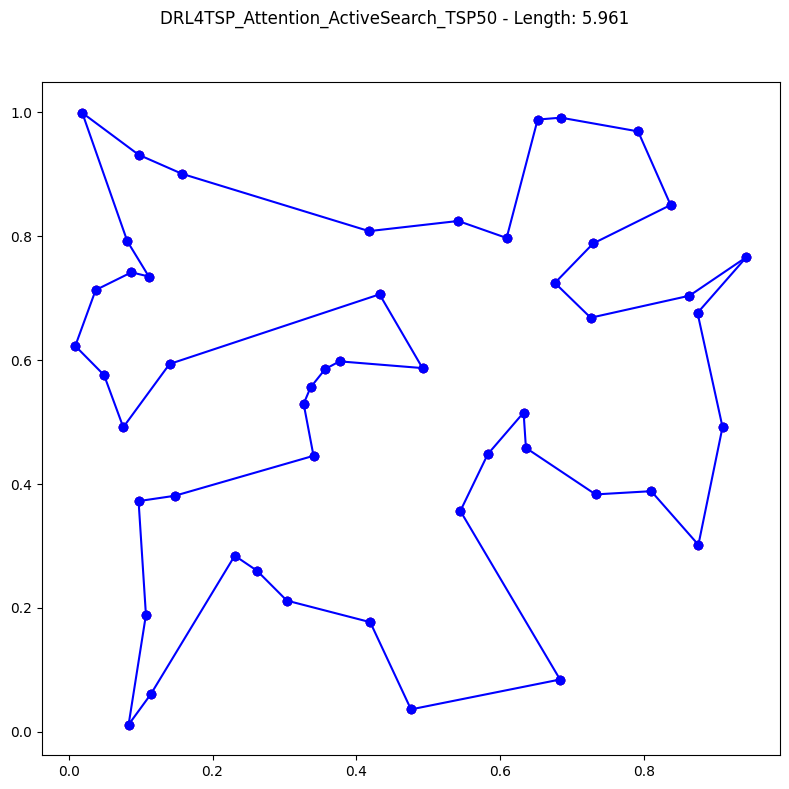

Training completed!


In [14]:
print('Training started...')
train(args, train_dataset)
print('Training completed!')